In [2]:
import json
import pandas as pd
import numpy as np
import random
from bidict import bidict
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from itertools import chain
from collections import Counter, defaultdict
import re
from statistics import median, median_high, variance, stdev, mean, mode
from ggplot import ggplot, aes, geom_point, geom_line, scale_y_log
import os
import time
import math
from ggplot import ggplot, aes, geom_point, geom_line
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [48]:
%matplotlib inline

In [49]:
sns.set(style="darkgrid", color_codes=True)
plt.style.use('ggplot')

In [50]:
#df = pd.read_pickle("/data/rali7/Tmp/solimanz/data/pickles/clean_2017_11_28.pkl")
df = pd.read_pickle("/data/rali7/Tmp/solimanz/data/pickles/excerpt-2017-02-20_reduced.pkl")
#with open("/data/rali7/Tmp/solimanz/data/pickles/test_ids.pkl", "rb") as f:
#    test_ids = pickle.load(f)
#with open("/data/rali7/Tmp/solimanz/data/pickles/train_ids.pkl", "rb") as f:
#    test_ids = pickle.load(f)

In [5]:
industries_dist = df.industry.value_counts(normalize=True)

In [51]:
func_counts = df.transformed.value_counts(normalize=True)

In [32]:
dat = {"title": [i for i, t in enumerate(func_counts.index.values)], "freq": func_counts.values}

In [33]:
df = pd.DataFrame(dat)

In [56]:
all_ids = df._id.unique()
bad_ids = df[~df.transformed.isin(func_counts.index[:550])]._id.unique()
to_keep = list(set(all_ids) - set(bad_ids))

In [58]:
func_counts = df[df._id.isin(to_keep)].transformed.value_counts(normalize=True)

Text(0.5,1,'Distribution of Job Title Strings in Log Scale')

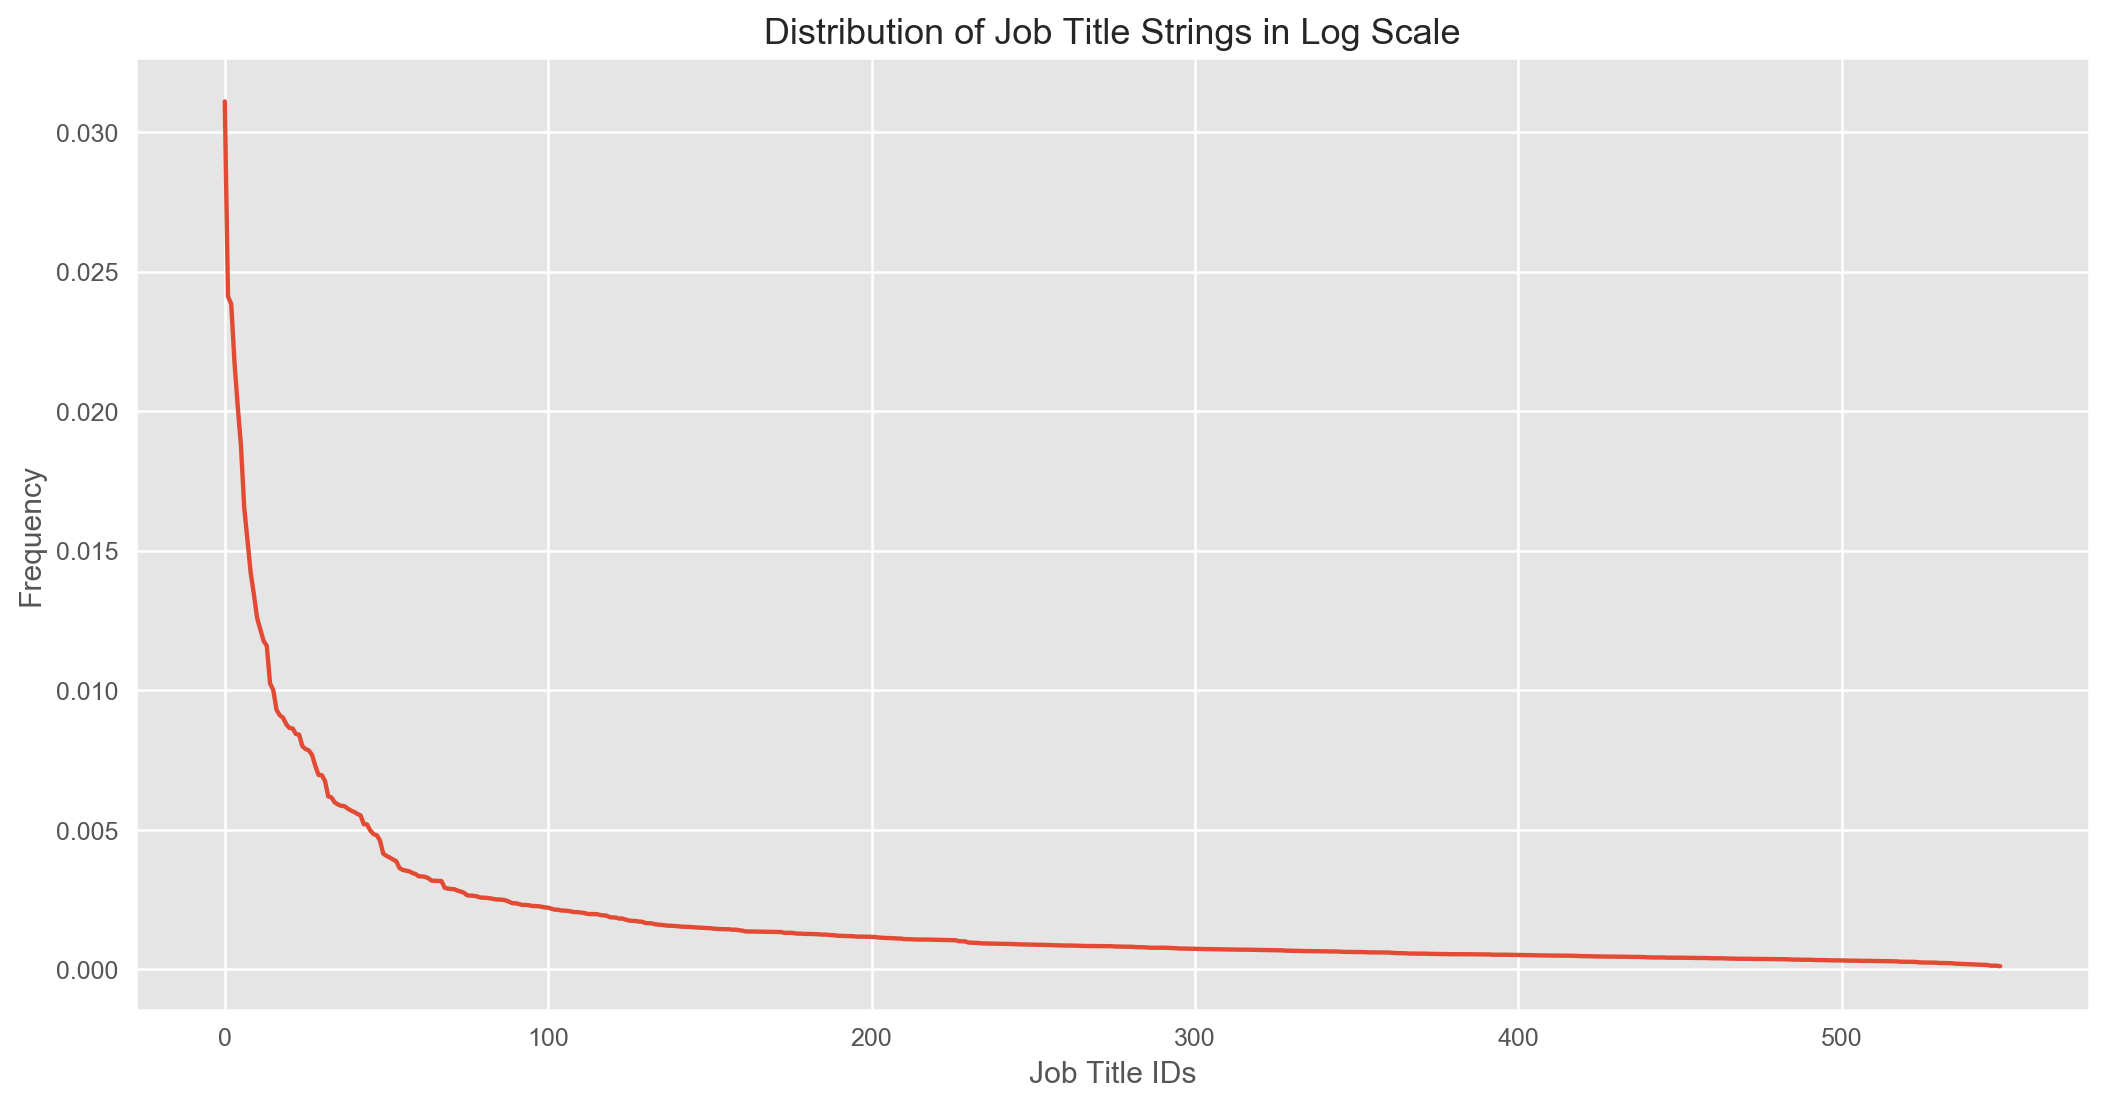

In [59]:
plt.rcParams['figure.figsize'] = 14, 7
plt.rcParams['figure.dpi'] = 180

plt.plot([i for i, t in enumerate(func_counts.index.values[:550])], func_counts.values[:550])
#plt.yscale('log')

plt.xlabel("Job Title IDs")
plt.ylabel("Frequency")
plt.title("Distribution of Job Title Strings in Log Scale")

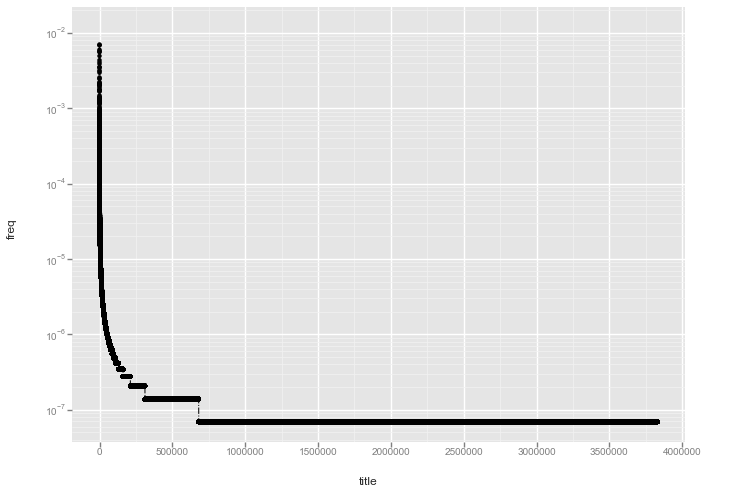

<ggplot: (-9223363281894102759)>

In [38]:
ggplot(aes(x='title', y='freq'), data=df) + geom_point() + geom_line(aes(linetype='dashdot')) + scale_y_log(base=10)

In [7]:
all_ids = df._id.unique()
bad_ids = df[~df.transformed.isin(func_counts.index[:550])]._id.unique()
filtered_df = df[~df._id.isin(bad_ids)]

In [8]:
filtered_counts = filtered_df.transformed.value_counts(normalize=True)

In [9]:
plt.rcParams['figure.figsize'] = 10, 100
plt.rcParams['figure.dpi'] = 100
plt.rcParams['axes.titlepad'] = 25

### Distribution of job titles by considering top 550 titles and all industries

In [5]:
#ax = sns.barplot(x=filtered_counts.values, y=filtered_counts.index.values, label='freq. of job titles', log=False)
#plt.setp(ax.get_xticklabels(), rotation=90)
#ax.xaxis.tick_top()
#ax.set_title("freq. of job titles")

In [7]:
sum(industries_dist.values[:80])

0.90882957346403226

$90\%$ of profiles are working in the top 80 industries $\approx 50\%$ of all industries available

In [9]:
df[df.industry.isin(industries_dist.index[:50])]._id.nunique()

1800662

In [10]:
filtered_df = df[df.industry.isin(industries_dist.index[:50])]

In [11]:
func_dist = filtered_df.transformed.value_counts(normalize=True) * 100

# Explore Distribution of Job Transitions

In [11]:
grouped = filtered_df.groupby("_id")

In [28]:
job_seqs = grouped.transformed.apply(lambda x: list(reversed(list(x))))

In [29]:
transitions = job_seqs.apply(lambda x: list(zip(x, x[1:])))

In [30]:
transitions = chain.from_iterable(transitions.values)

In [31]:
transition_count = Counter(transitions)

In [32]:
total_transitions = sum(transition_count.values())

In [33]:
total_transitions

318392

In [34]:
#title_id_mapping = bidict({title: i for i, title in enumerate(func_count.index.values)})

In [ ]:
transition_matrix = np.zeros((550,550), dtype=np.float32)
for (x,y), c in transition_count.items():
    transition_matrix[title_id_mapping[x], title_id_mapping[y]] = c / total_transitions    

In [35]:
freqs = {str(key): (val/total_transitions) for key, val in transition_count.items()}

In [36]:
t = pd.Series(freqs).sort_values(ascending=False)

In [41]:
plt.rcParams['figure.figsize'] = 10, 40
plt.rcParams['figure.dpi'] = 100
plt.rcParams['axes.titlepad'] = 25

In [6]:
#ax = sns.barplot(x=t.values[:200], y=t.index.values[:200], label='freq. of job transitions', log=False)
#plt.setp(ax.get_xticklabels(), rotation=90)
#ax.xaxis.tick_top()
#ax.set_title("freq. of job transitions")

In [52]:
tot = 0
for t in transition_count.keys():
    if t[0] == t[1]:
        tot += 1

In [55]:
100* (tot/total_transitions)

0.1724289555013945

In [ ]:
func_counts = df[df.transformed.isin(func_counts.index[:550])].transformed

In [18]:
joined = " ".join(func_counts.index.values)
tokens = re.split(r"[-/,\.\\\s]", joined)
token_counts = Counter(tokens)

In [165]:
del token_counts['']
del token_counts[':']

In [166]:
to_remove = stopwords.words('english')

In [167]:
for w in to_remove:
    if w in token_counts:
        del token_counts[w]

In [168]:
total = sum(token_counts.values())

In [169]:
normalized_tokens_count = Counter({k:100*(v/total) for k, v in token_counts.items()})

In [170]:
size = len(token_counts)

In [171]:
size

180954

In [172]:
values = np.array(sorted(normalized_tokens_count.values(), reverse=True))

In [173]:
x = np.arange(1, size, dtype=np.int32)
y = [np.sum(values[:i]) for i in x]

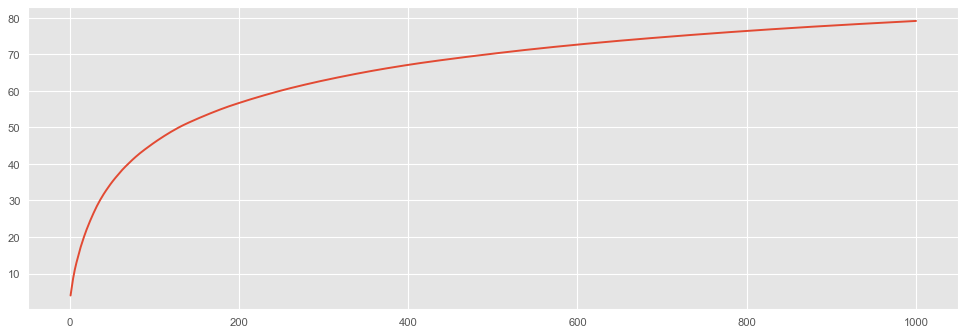

In [174]:
plt.rcParams['figure.figsize'] = 15, 5
plt.rcParams['figure.dpi'] = 80
plt.plot(x[:1000], y[:1000])

In [178]:
tokens = token_counts.most_common(1000)
values = {k: v for k, v in tokens}
tokens = [t[0] for t in tokens]

We try to transform job titles into combinations of available tokens and see what happens

In [202]:
def transform(s, tokens, values):
    split = re.split(r"[-/,\.\\\s]", s)
    return '/'.join(sorted(filter(lambda x: x in tokens, split), key=lambda x: values[x]))

In [208]:
applied = df.transformed.apply(transform, args=(tokens, values))

In [212]:
df['token_trans'] = applied

In [214]:
df.token_trans.nunique()

1656843

In [215]:
df.transformed.nunique()

3161930

In [216]:
df.function.nunique()

3502165

In [218]:
func_dist = df.token_trans.value_counts(normalize=True) * 100

In [230]:
x2 = np.arange(1, 100000, dtype=np.int32)
y2 = [np.sum(func_dist.values[:i]) for i in x2]

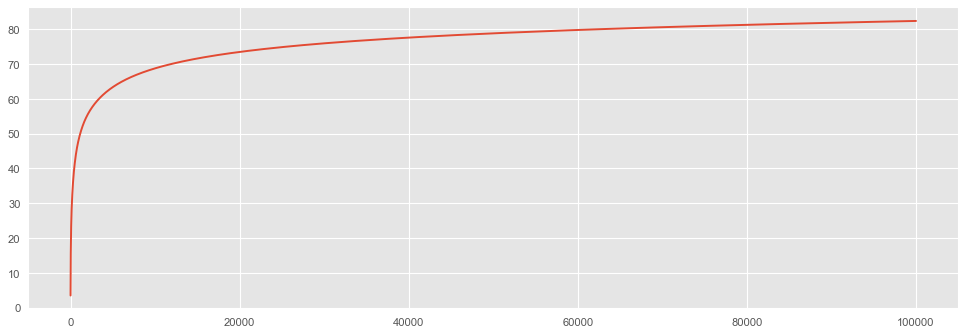

In [232]:
plt.plot(x2[:], y2[:])

In [2]:
df.to_pickle("/data/rali7/Tmp/solimanz/data/pickles/add_tok_trans.pkl")

NameError: name 'df' is not defined

In [7]:
ds1_path = "/data/rali7/Tmp/solimanz/data/datasets/top550/1/"
ds1_file_name = "title_sequences"

In [8]:
with open(os.path.join(ds1_path, f"{ds1_file_name}.json"), 'r') as f:
    data = json.load(f)

In [9]:
sequences = data['train_data'] # + data['test_data']

In [10]:
max_len = max([len(s) for s in sequences])

In [11]:
title_id = bidict(data['title_to_id'])

In [12]:
len(sequences)

96297

In [13]:
max_len

32

In [56]:
def get_subsequences(seqs):
    for length in range(1, max_len):
        for seq in seqs:
            if len(seq) >= length:
                yield tuple(seq[:length])

In [57]:
counts = Counter(get_subsequences(sequences))

In [58]:
multi_label = defaultdict(set)

In [59]:
for sub_seq in counts.keys():
    if len(sub_seq) > 1:
        multi_label[sub_seq[:-1]].add(sub_seq[-1])

In [60]:
len(multi_label)

1271904

In [15]:
lengths = sorted({len(k) for k in counts.keys()})

In [16]:
seq_lengths = defaultdict(list)
for k, v in multi_label.items():
    seq_lengths[len(k)].append(len(v))

In [120]:
all( k == i+1 for i, k in  enumerate(seq_lengths.keys()))

True

In [161]:
lists = sorted(seq_lengths.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples
y = [max(i) for i in y]
#y = [sum(i)/len(i) for i in y]

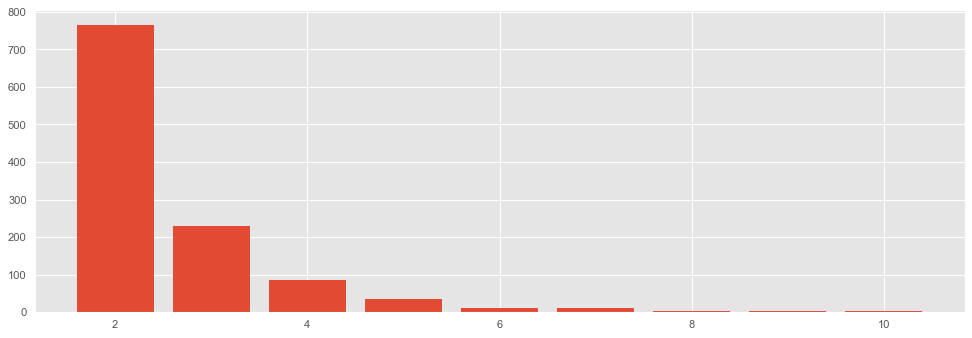

In [162]:
plt.rcParams['figure.figsize'] = 15, 5
plt.rcParams['figure.dpi'] = 80
plt.bar(x[1:10], y[1:10])
plt.xlabel("Sub sequence length")
plt.ylabel("Maximum number of next step posibilities")
plt.show()

In [17]:
dat = {"length": [], "n_next_step": []}

In [18]:
for k, v in seq_lengths.items():   
    if k <= 5:
        for elem in v:      
            dat["length"].append(k)
            dat["n_next_step"].append(elem)

In [19]:
df = pd.DataFrame(dat)

In [62]:
graph = defaultdict(list)

for sequence in sequences:
    for prev, nxt in zip(sequence[:-1], sequence[1:]):
        graph[prev].append(nxt)        

In [65]:
n_childrens = [len(c) for c in graph.values()]

In [54]:
to_remove = set(stopwords.words("english") + ['', ' ', '&'])
joined = " ".join(df.transformed.values)
pattrn = re.compile(r"[-/,\.\\\s]")
tokens = re.split(pattrn, joined)

token_counts = Counter(tokens)

In [59]:
filtered_tokens = list(filter(lambda tok: tok not in to_remove, tokens))

In [60]:
def get_ngrams(n, tokens):    
    return [tuple(tokens[i:i+n]) for i in range(len(tokens)-n+1)]

In [61]:
unigrams = get_ngrams(1, filtered_tokens)
bigrams = get_ngrams(2, filtered_tokens)
trigrams = get_ngrams(3, filtered_tokens)

In [64]:
ngrams = unigrams + bigrams + trigrams

In [66]:
ngram_counts = Counter(ngrams)

In [6]:
for bad in to_remove:
    del token_counts[bad]

In [7]:
vocab = bidict({tok: i for i, tok in enumerate(token_counts.keys())})

In [10]:
ls = token_counts.most_common(len(token_counts))

In [20]:
x = list(range(len(ls)))
y = [t[1] for t in ls]

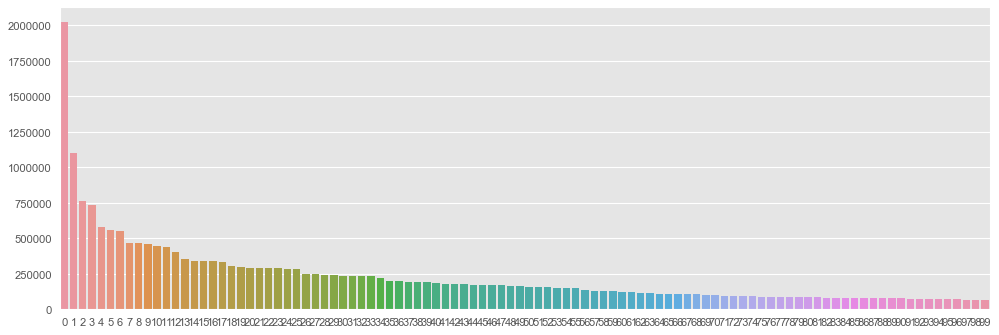

In [22]:
plt.rcParams['figure.figsize'] = 15, 5
plt.rcParams['figure.dpi'] = 80
sns.barplot(x=x[:100], y=y[:100])

In [99]:
to_remove = set(stopwords.words("english") + ['', ' ', '&'])
pattrn = re.compile(r"[-/,\.\\\s]")

def get_best(s, to_remove, pattrn, ngram_counts):
    tokens = re.split(pattrn, s)
    tokens = list(filter(lambda tok: tok not in to_remove, tokens))
    
    if len(tokens) == 0:
        return "<unk>"

    unigram = max(get_ngrams(1, tokens), key=lambda x: ngram_counts[x], default=())
    bigram = max(get_ngrams(2, tokens), key=lambda x: ngram_counts[x], default=())
    trigram = max(get_ngrams(3, tokens), key=lambda x: ngram_counts[x], default=())
    
    if trigram and ngram_counts[trigram] > 100:
        return " ".join(trigram)
    elif bigram and ngram_counts[bigram] > 100:
        return " ".join(bigram)
    else:
        return unigram[0]

In [98]:
ngram_counts[('tutorial', 'assistant')]

131

In [87]:
funcs = df.transformed.unique()

In [100]:
mapping = dict()

for func in funcs:
    mapping[func] = get_best(func, to_remove, pattrn, ngram_counts)

In [101]:
c = Counter(mapping.values())

In [102]:
#[k for k, v in mapping.items() if v == 'assistant']

In [103]:
len(mapping)

3830435

In [104]:
len(c)

90960

In [106]:
df['mapped'] = df.transformed.apply(lambda s: mapping[s])

In [107]:
def compute_examples_n(ranks_counts, lower=100, upper=1500000, step=100):
    #top_ks = np.arange(10, 600000, 100)
    top_ks = np.arange(lower, upper, step)
    n_examples = []
    
    for k in top_ks:
        n_examples.append(rank_counts[:k].sum())
        
    return top_ks, n_examples

In [108]:
reduced_freq = df.mapped.value_counts()
df["title_rank"] = df.mapped.apply(lambda s: reduced_freq.index.get_loc(s))
id_ranks = df.groupby("_id")["title_rank"].max()
rank_counts = id_ranks.value_counts().sort_index()
x, y = compute_examples_n(rank_counts, lower=100, upper=1000000)

In [109]:
#ratios = [n_titles/n_ex for n_titles, n_ex in zip(top_ks, n_examples)]
x_gains = x[1:]
gains = [(100*(b - a))/a for a, b in zip(y[:-1], y[1:])]

Text(0,0.5,'Gain of training examples')

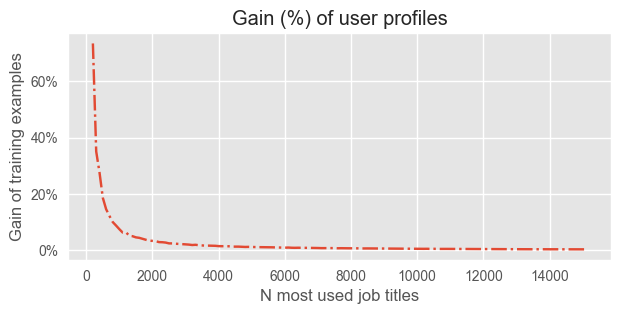

In [110]:
plt.rcParams['figure.figsize'] = 7, 3
plt.rcParams['figure.dpi'] = 100

plt.plot(x_gains[:150], gains[:150], '-.', alpha=1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in plt.gca().get_yticks()]) 
plt.title("Gain (%) of user profiles")
plt.xlabel("N most used job titles")
plt.ylabel("Gain of training examples")

In [118]:
reduced_freq[:4000]

customer service representative    138345
manager                            112191
sales associate                    109585
owner                              107138
project manager                    106989
administrative assistant            95075
research assistant                  93288
president                           85503
consultant                          83873
sales representative                83751
intern                              79618
director                            64028
account manager                     61495
teaching assistant                  60349
chief executive officer             58571
supervisor                          58303
cashier                             54892
general manager                     54765
assistant manager                   51317
software developer                  49301
volunteer                           48089
assistant                           44698
coordinator                         44176
instructor                        

In [114]:
all_ids = df._id.nunique()
bad_ids = df[~df.mapped.isin(reduced_freq.index[:4000])]._id.nunique()
all_ids - bad_ids

854280

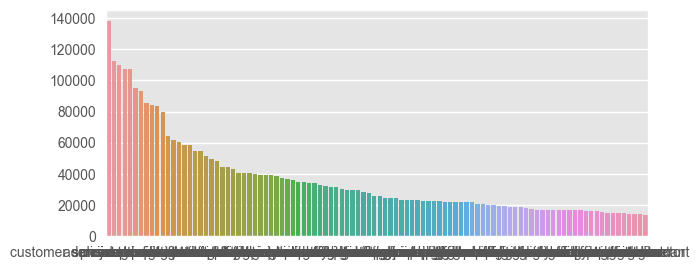

In [116]:
sns.barplot(x=reduced_freq.index.values[:100], y=reduced_freq.values[:100])

In [ ]:
df.to_pickle("/data/rali7/Tmp/solimanz/data/pickles/dataframe_v3.pkl")

In [ ]:
print('hello')